<a href="https://colab.research.google.com/github/baker371/Thesis/blob/main/Toxicity_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 5.7 MB/s 


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

warnings.filterwarnings('ignore')

In [ ]:
!git clone https://github.com/baker371/Drug-Discovery.git

Cloning into 'Drug-Discovery'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 184 (delta 4), reused 0 (delta 0), pack-reused 169
Receiving objects: 100% (184/184), 42.49 MiB | 4.07 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
%cd /content/Drug-Discovery/data

/content/Drug-Discovery/data


In [ ]:
tox = pd.read_csv('clintox.csv')
tox.head(3)

,smiles,FDA_APPROVED,CT_TOX
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0
2,[C@H]([C@@H]([C@@H](C(=O)[O-])O)O)([C@H](C(=O)...,1,0


#### Generating Molecular Fingerprints

RDKit ERROR: [10:07:40] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [10:07:41] Can't kekulize mol.  Unkekulized atoms: 9
RDKit ERROR: 
RDKit ERROR: [10:07:41] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [10:07:41] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [10:07:41] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 
RDKit ERROR: [10:07:41] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 


,smiles,FDA_APPROVED,CT_TOX,mol,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,1,0,,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,[C@@H]1([C@@H]([C@@H]([C@H]([C@@H]([C@@H]1Cl)C...,1,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

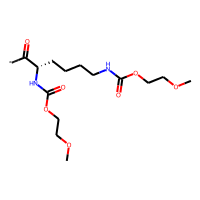
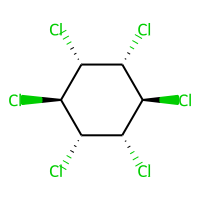

In [ ]:
PandasTools.AddMoleculeColumnToFrame(tox,'smiles','mol')
toxi = tox[tox['mol'].notna()]
toxi['FP'] = toxi.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x.mol, 2, 2048), axis=1)
FP = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in toxi.mol]
df_FP = pd.DataFrame(np.array(FP)) 
df_FP.index = toxi.index
dfo = pd.concat([toxi, df_FP], axis=1)
dfo = dfo.drop('FP', 1)
dfo.head(2)

#### Getting variable

---



In [ ]:
# Dependent variable (if a molecule is toxic or not) - Target
ydf = dfo[['CT_TOX']]
dt  = ydf.values
Y   = dt[:,0]
Y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
dfo.drop(['smiles', 'mol','CT_TOX'], axis=1, inplace=True)
dfo.shape

(1478, 2049)

In [ ]:
# Independent variables (Features)
dx = dfo.values
X = dx[:,0:2049]
X

array([[1, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Split the data into 80% training and 20% (testing (10%), validation(10%))
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(1182, 2049) (148, 2049) (148, 2049) (1182,) (148,) (148,)


#### Building the model and architecture of the deep neural network

In [ ]:
model = Sequential() # Initialising the DNN
model.add(Dense(units=32, activation='relu', input_dim=2049))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Loss functio  to measue how well the model performed on training,then tries to improve it using the optimizer

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
hist = model.fit(
    X_train,Y_train,
    batch_size=32,epochs=200,
    validation_data=(X_val, Y_val)
)

Epoch 1/200
37/37 [==============================] - 1s 9ms/step - loss: 0.6465 - accuracy: 0.7733 - val_loss: 0.5815 - val_accuracy: 0.9189
Epoch 2/200
37/37 [==============================] - 0s 4ms/step - loss: 0.5115 - accuracy: 0.9213 - val_loss: 0.4592 - val_accuracy: 0.9189
Epoch 3/200
37/37 [==============================] - 0s 3ms/step - loss: 0.3941 - accuracy: 0.9213 - val_loss: 0.3622 - val_accuracy: 0.9189
Epoch 4/200
37/37 [==============================] - 0s 4ms/step - loss: 0.3169 - accuracy: 0.9213 - val_loss: 0.3130 - val_accuracy: 0.9189
Epoch 5/200
37/37 [==============================] - 0s 5ms/step - loss: 0.2806 - accuracy: 0.9213 - val_loss: 0.2925 - val_accuracy: 0.9189
Epoch 6/200
37/37 [==============================] - 0s 4ms/step - loss: 0.2650 - accuracy: 0.9213 - val_loss: 0.2841 - val_accuracy: 0.9189
Epoch 7/200
37/37 [==============================] - 0s 4ms/step - loss: 0.2565 - accuracy: 0.9213 - val_loss: 0.2780 - val_accuracy: 0.9189
Epoch 8/200
3

In [ ]:
model.evaluate(X_test, Y_test)[1]

5/5 [==============================] - 0s 3ms/step - loss: 0.1185 - accuracy: 0.9797


0.9797297120094299

In [ ]:
# Make Prediction with a cutoff point of the 97% accuracy as evaluated

pred = model.predict(X_test)
pred = [1 if y>=0.97 else 0 for y in pred]

print('original : {0}'.format(", ".join(str(x) for x in Y_test)))
print('predicted : {0}'.format(", ".join(str(x) for x in pred)))

original : 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
predicted : 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0


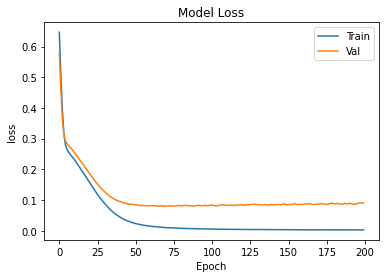

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.savefig('loss.png')

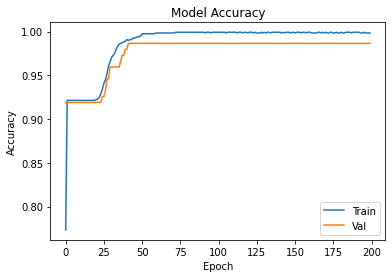

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.savefig('accuracy.png')

In [ ]:
pickle.dump(model, open('model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://5620d580-3ac1-4a19-9d83-56efee537c5d/assets


#### Predicting on the Lipopeptides

In [ ]:
lp = pd.read_csv('final.csv')
lp.head(3)

,uid,smiles,similarity
0,NPA003990,CC(C)CCCCCCC1CC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C...,1.0
1,UNPD102124,CNC(CC(C)C)C(=O)NC1C(O)c2ccc(Oc3cc4cc(Oc5ccc(c...,1.0
2,NPA010755,CCC(C)CC(C)CCCCCCCCC(=O)N[C@H]1C[C@H]([C@H](NC...,1.0


,uid,smiles,similarity,mol,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,NPA003990,CC(C)CCCCCCC1CC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C...,1.0,,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,UNPD102124,CNC(CC(C)C)C(=O)NC1C(O)c2ccc(Oc3cc4cc(Oc5ccc(c...,1.0,,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0

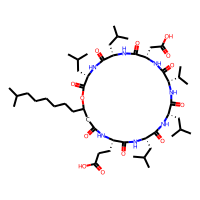
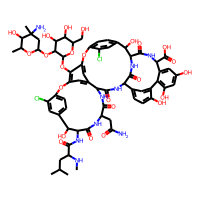

In [ ]:
PandasTools.AddMoleculeColumnToFrame(lp,'smiles','mol')
lipo = lp[lp['mol'].notna()]
lipo['FP'] = lipo.apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x.mol, 2, 2048), axis=1)
FP = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in lipo.mol]
dfp = pd.DataFrame(np.array(FP)) 
dfp.index = lipo.index
dfn = pd.concat([lipo, dfp], axis=1)
dfn = dfn.drop('FP', 1)
dfn.head(2)

In [ ]:
dfn.drop(['smiles', 'mol','uid'], axis=1, inplace=True)
dfn.shape

(2977, 2049)

In [ ]:
# Features to Predict
dxx = dfn.values
M = dxx[:,0:2049]
M

array([[1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.24, 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.24, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.24, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [ ]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [ ]:
prediction = pickled_model.predict(M)
prediction = [1 if y>=0.97 else 0 for y in prediction]

,uid,smiles,similarity,mol,CT_TOX
0,NPA003990,CC(C)CCCCCCC1CC(=O)N[C@H](C(=O)N[C@H](C(=O)N[C...,1.000000,,0
1,UNPD102124,CNC(CC(C)C)C(=O)NC1C(O)c2ccc(Oc3cc4cc(Oc5ccc(c...,1.000000,,0
2,NPA010755,CCC(C)CC(C)CCCCCCCCC(=O)N[C@H]1C[C@H]([C@H](NC...,1.000000,,0
3,NPA006287,CC(C)CCCCCCCCC1CC(=O)N[C@H](C(=O)N[C@H](C(=O)N...,1.000000,,0
4,NPA005839,CC1C(C(CC(O1)OC2C(C(C(OC2OC3=C4C=C5C=C3OC6=C(C...,0.962963,,0
5,NPA010156,CC[C@H](C)CCCCC(=O)NC(CCN)C(=O)NC(C(C)O)C(=O)N...,0.943182,,0
6,NPA017927,CCC1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NCCC(C(=O)NC(...,0.925926,,0
7,NPA021129,CC[C@H](C)CCCCC(=O)N[C@H](CCN)C(=O)N[C@H]([C@H...,0.920455,,0
8,NPA012930,CC[C@H](C)CCCCC(=O)NC(CCN)C(=O)NC(C(C)O)C(=O)N...,0.914634,,0
9,NPA021351,C[C@@H]1[C@H]([C@@](C[C@@H](O1)O[C@H]2[C@H]([C...,0.913669,,0

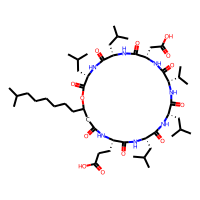
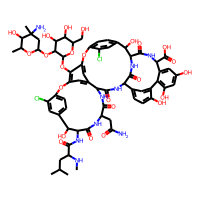
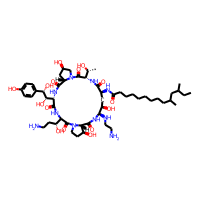
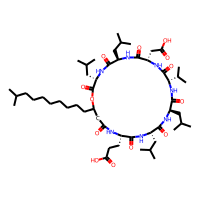
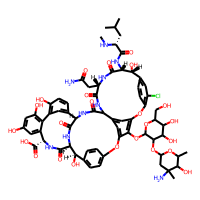
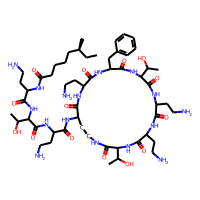
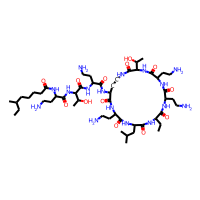
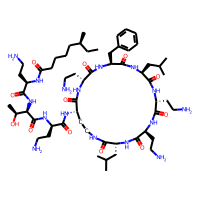
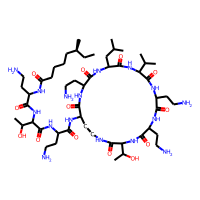
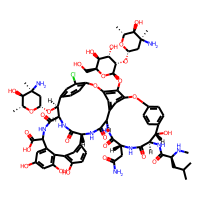

In [ ]:
lp['CT_TOX'] = prediction
lp.head(10)

In [ ]:
lp.shape

(2977, 5)

In [ ]:
non_toxic = lp[lp.CT_TOX == 0]
non_toxic.shape

(2801, 5)

In [ ]:
ex = non_toxic[['uid','smiles','similarity']]
ex.to_csv (r'non_toxic.csv', index = False, header=True)